# TP 8 sur différentes variantes du   Lasso

1. récupérez les données du premier TP

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

url_data = "https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data"
df = pd.read_csv(url_data, delimiter='\t') 

In [2]:
variables = df.columns[1:9]
df[variables] = df[variables].apply(lambda x: (x - x.mean()) / x.std())

In [3]:
# Get the training and test sets
Y_train = df.loc[df["train"]=="T", 'lpsa'].to_numpy()
X_train = df.loc[df["train"]=="T", variables].to_numpy()
print("Training set : n = {} samples and p = {} dimensions".format(X_train.shape[0], X_train.shape[1]))

Y_test = df.loc[df["train"]=="F", 'lpsa'].to_numpy()
X_test = df.loc[df["train"]=="F", variables].to_numpy()
print("Test set : n = {} samples and p = {} dimensions".format(X_test.shape[0], X_test.shape[1]))

nt = X_test.shape[0]
X_test_1 = np.hstack((np.ones((nt,1)),X_test))

Training set : n = 67 samples and p = 8 dimensions
Test set : n = 30 samples and p = 8 dimensions


2. Recherchez la solution du lasso telle qu'elle à été publiée dans le livre (cf TP1)

In [4]:
import cvxpy as cp

Xn = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
Yn = (Y_train - Y_train.mean())/Y_train.std()
n, p = Xn.shape

ybar = Y_train.mean()
stdy = Y_train.std()
xbar = X_train.mean(0)
stdx = X_train.std(0)

lam = 23.38
b = cp.Variable(p)
o = cp.Minimize(cp.sum_squares(Xn@b-Yn) + lam*cp.norm(b, 1))
problem = cp.Problem(o)
problem.solve(solver=cp.SCS,eps=1e-5)

b0_lasso =  ybar - stdy*((xbar/stdx).T@b.value)
b_lasso = b.value*Y_train.std()/X_train.std(axis=0)
beta_lasso = np.concatenate((np.array([b0_lasso]),b_lasso))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print("Estimation: ",beta_lasso)

(CVXPY) Nov 03 05:42:04 PM: Encountered unexpected exception importing solver OSQP:
ImportError("dlopen(/Users/stephane/anaconda3/lib/python3.11/site-packages/osqp/_osqp.cpython-311-darwin.so, 0x0002): symbol not found in flat namespace '_csc_matrix'")
Estimation:  [ 2.468  0.533  0.169 -0.000  0.002  0.094 -0.000 -0.000 -0.000]


3. Recherchez la solution de l'elastic net 

$$
	J_{\mbox{el}} (\beta)  \; = \;   \|  X\beta - y\|^2 +   \lambda \|\beta\|_1 +    {\gamma} \|\beta\|_2^2  \; , 
$$

3.1 comme un QP

In [16]:
import cvxpy as cp

lam = 12
lam2 = 0.01
b = cp.Variable(p)
o = cp.Minimize(cp.sum_squares(Xn@b-Yn) + lam*cp.norm(b, 1)+ lam2*cp.norm(b, 2)**2)
problem = cp.Problem(o)
problem.solve(solver=cp.SCS,eps=1e-5)

b0_EN =  ybar - stdy*((xbar/stdx).T@b.value)
b_EN = b.value*Y_train.std()/X_train.std(axis=0)
beta_EN = np.concatenate((np.array([b0_EN]),b_EN))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print("Estimation: ",beta_EN)
ytp = X_test_1@beta_EN
err = ytp - Y_test
testErr = np.mean(err**2,axis=0)
print("Error: {:>12.5f}{:>12.3f}{:>12.3f}".format(testErr, lam, lam2))

Estimation:  [ 2.466  0.544  0.205  0.000  0.098  0.165 -0.000  0.000  0.059]
Error:      0.45234      12.000       0.010


3.2 Comme un probleme de lasso

In [15]:
lam = 12
lam2 = 0.01
Xen = np.vstack((Xn,np.sqrt(lam2)*np.eye(p)))
Yen = np.hstack((Yn,np.zeros(p)))
b = cp.Variable(p)
o = cp.Minimize(cp.sum_squares(Xen@b-Yen) + lam*cp.norm(b, 1))
problem = cp.Problem(o)
problem.solve(solver=cp.SCS,eps=1e-5)

b0_EN =  ybar - stdy*((xbar/stdx).T@b.value)
b_EN = b.value*Y_train.std()/X_train.std(axis=0)
beta_EN = np.concatenate((np.array([b0_EN]),b_EN))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print("Estimation: ",beta_EN)
ytp = X_test_1@beta_EN
err = ytp - Y_test
testErr = np.mean(err**2,axis=0)
print("Error: {:>12.5f}{:>12.3f}{:>12.3f}".format(testErr, lam, lam2))

Estimation:  [ 2.466  0.544  0.205  0.000  0.098  0.165 -0.000 -0.000  0.059]
Error:      0.45234      12.000       0.010


4. Résoudrele problème du lasso adaptatif

4.1  comme un QP 

In [6]:
nt = X_test.shape[0]
X_test_1 = np.hstack((np.ones((nt,1)),X_test))

lam = 6. #np.arange(1, 10, 0.5)
w = np.linalg.solve(Xn.T@Xn,Xn.T@Yn)
w = 1/np.sqrt(np.abs(w))

b = cp.Variable(p)
o = cp.Minimize(cp.sum_squares(Xn@b-Yn) + lam*cp.norm(cp.multiply(w,b), 1))
problem = cp.Problem(o)
problem.solve(solver=cp.SCS,eps=1e-5)
    
b0_lasso =  ybar - stdy*((xbar/stdx).T@b.value)
b_Ad_lasso = b.value*Y_train.std()/X_train.std(axis=0)
b_Ad_lasso = np.concatenate((np.array([b0_lasso]),b_Ad_lasso))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print("Estimation: ",b_Ad_lasso)
ytp = X_test_1@b_Ad_lasso
err = ytp - Y_test
testErr = np.mean(err**2,axis=0)
print("Error: {:>12.3f}{:>12.3f}".format(testErr, lam))

Estimation:  [ 2.469  0.613  0.202  0.000  0.068  0.132  0.000  0.000  0.036]
Error:        0.439       6.000


4.2 comme un probleme de lasso

In [7]:
lam = 6.
Xw = Xn/w
b = cp.Variable(p)
o = cp.Minimize(cp.sum_squares(Xw@b-Yn) + lam*cp.norm(b, 1))
problem = cp.Problem(o)
problem.solve(solver=cp.SCS,eps=1e-5)

b_Ad_lasso_2 = b.value/w

b0_lasso =  ybar - stdy*((xbar/stdx).T@b_Ad_lasso_2)
b_Ad_lasso_2 = b_Ad_lasso_2*Y_train.std()/X_train.std(axis=0)
b_Ad_lasso_2 = np.concatenate((np.array([b0_lasso]),b_Ad_lasso_2))

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print("Estimation: ",b_Ad_lasso_2)
ytp = X_test_1@b_Ad_lasso_2
err = ytp - Y_test
testErr_2 = np.mean(err**2,axis=0)
print("Error: {:>12.3f}{:>12.3f}".format(testErr_2, lam))

Estimation:  [ 2.469  0.613  0.202 -0.000  0.068  0.132  0.000  0.000  0.036]
Error:        0.439       6.000


5. Comparez les résultats

In [8]:
B = np.stack((beta_lasso.T, beta_EN.T, b_Ad_lasso.T)).T
ytp = X_test_1@B
err = ytp - np.outer(Y_test,np.ones(3))
testErr = np.mean(err**2,axis=0)

StdErr = np.std(err**2,axis=0, ddof=1)/np.sqrt(nt)

print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}".format("Test Error",testErr[0],testErr[1],testErr[2]))

Test Error       0.479       0.452       0.439


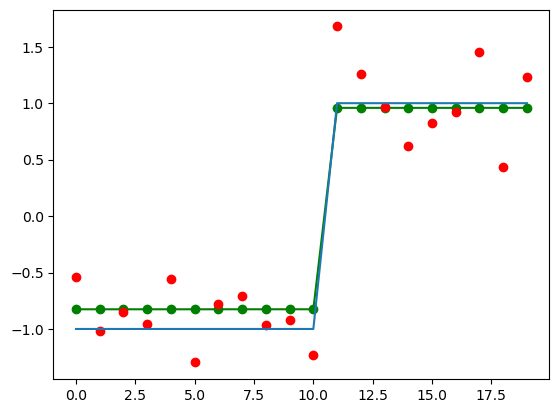

In [11]:
x = np.arange(-1, 1, .1)
n = len(x)
stdnoise = 0.3
y = np.sign(x) + np.random.randn(n)*stdnoise

D = np.zeros((n-1, n))
np.fill_diagonal(D, 1)
np.fill_diagonal(D[:, 1:], -1)

lam = 1.5
b = cp.Variable(n)
o = cp.Minimize(cp.sum_squares(b-y) + lam*cp.norm(D@b, 1))
problem = cp.Problem(o)
problem.solve(solver=cp.SCS,eps=1e-5)
    
plt.plot(b.value,'-og')
plt.plot(y,'or')
plt.plot(np.sign(x))
plt.show()

In [10]:
n = 3
D = np.zeros((n-1, n))
np.fill_diagonal(D, 1)
np.fill_diagonal(D[:, 1:], -1)
print(D)

[[ 1.000 -1.000  0.000]
 [ 0.000  1.000 -1.000]]
